# This is Lab 4 executable file

This file contains program code, which is the solution to the problems in the file [lab_4_task.txt](https://github.com/RazinAleksandr/M-M-MSA-ITMO/blob/main/Lab_4/lab_4_task.txt)

In [356]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# FEDOT framework
from fedot.core.data.data import InputData
from fedot.core.pipelines.pipeline import Pipeline
from fedot.core.pipelines.node import PrimaryNode, SecondaryNode
from fedot.core.repository.dataset_types import DataTypesEnum
from fedot.core.repository.tasks import Task, TaskTypesEnum, TsForecastingParams
from fedot.core.data.data_split import train_test_data_setup

from statsmodels.tsa.stattools import adfuller, acovf, ccovf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

import pmdarima as pm

from scipy import signal

from pykalman import KalmanFilter

import warnings
warnings.filterwarnings("ignore")

## Exercise №1

Choose about 3-6 variables from your dataset (2-3 – target variables, the rest - predictors).

In [220]:
# Data init
path = '/home/aleksrazin/ITMO/M&MSA/train_data/covid_19_ts.csv'
df = pd.read_csv(path, index_col=0)

# Preprocessing
df.daterep = pd.to_datetime(df.daterep, format='%Y-%m-%d %H:%M:%S')
df.sort_values(by='daterep', inplace=True)
df.reset_index(drop=True, inplace=True)

# Group by date
df_grouped = df.groupby('daterep', as_index=False).\
                        agg({'cases':'sum', 
                             'deaths': 'mean',
                             'cumulative_number_for_14_days_of_covid_19_cases_per_100000': 'mean',
                             'popdata2019': 'mean'})
df_grouped.rename(columns={'cumulative_number_for_14_days_of_covid_19_cases_per_100000': 'cumulative_number'}, 
                  inplace=True)

# Choose variables
# target:
target = ['cases', 'deaths']
# predictors:
predictors = ['cumulative_number', 'popdata2019']

df_grouped.head(15)

,daterep,cases,deaths,cumulative_number,popdata2019
0,2019-12-31,27,0.000000,NaN,8.788834e+07
1,2020-01-01,0,0.000000,NaN,8.788834e+07
2,2020-01-02,0,0.000000,NaN,8.788834e+07
3,2020-01-03,17,0.000000,NaN,8.788834e+07
4,2020-01-04,0,0.000000,NaN,8.788834e+07
5,2020-01-05,15,0.000000,NaN,8.788834e+07
6,2020-01-06,0,0.000000,NaN,8.788834e+07
7,2020-01-07,0,0.000000,NaN,8.788834e+07
8,2020-01-08,0,0.000000,NaN,8.788834e+07
9,2020-01-09,0,0.000000,NaN,8.788834e+07


In [221]:
df_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   daterep            212 non-null    datetime64[ns]
 1   cases              212 non-null    int64         
 2   deaths             212 non-null    float64       
 3   cumulative_number  199 non-null    float64       
 4   popdata2019        212 non-null    float64       
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 8.4 KB


In [222]:
# Fill NaN values with spline to obtain a smooth surface passing through the input points
df_grouped['cumulative_number'].\
    interpolate(method='spline', order=1, limit_direction='backward', limit=30, inplace=True)

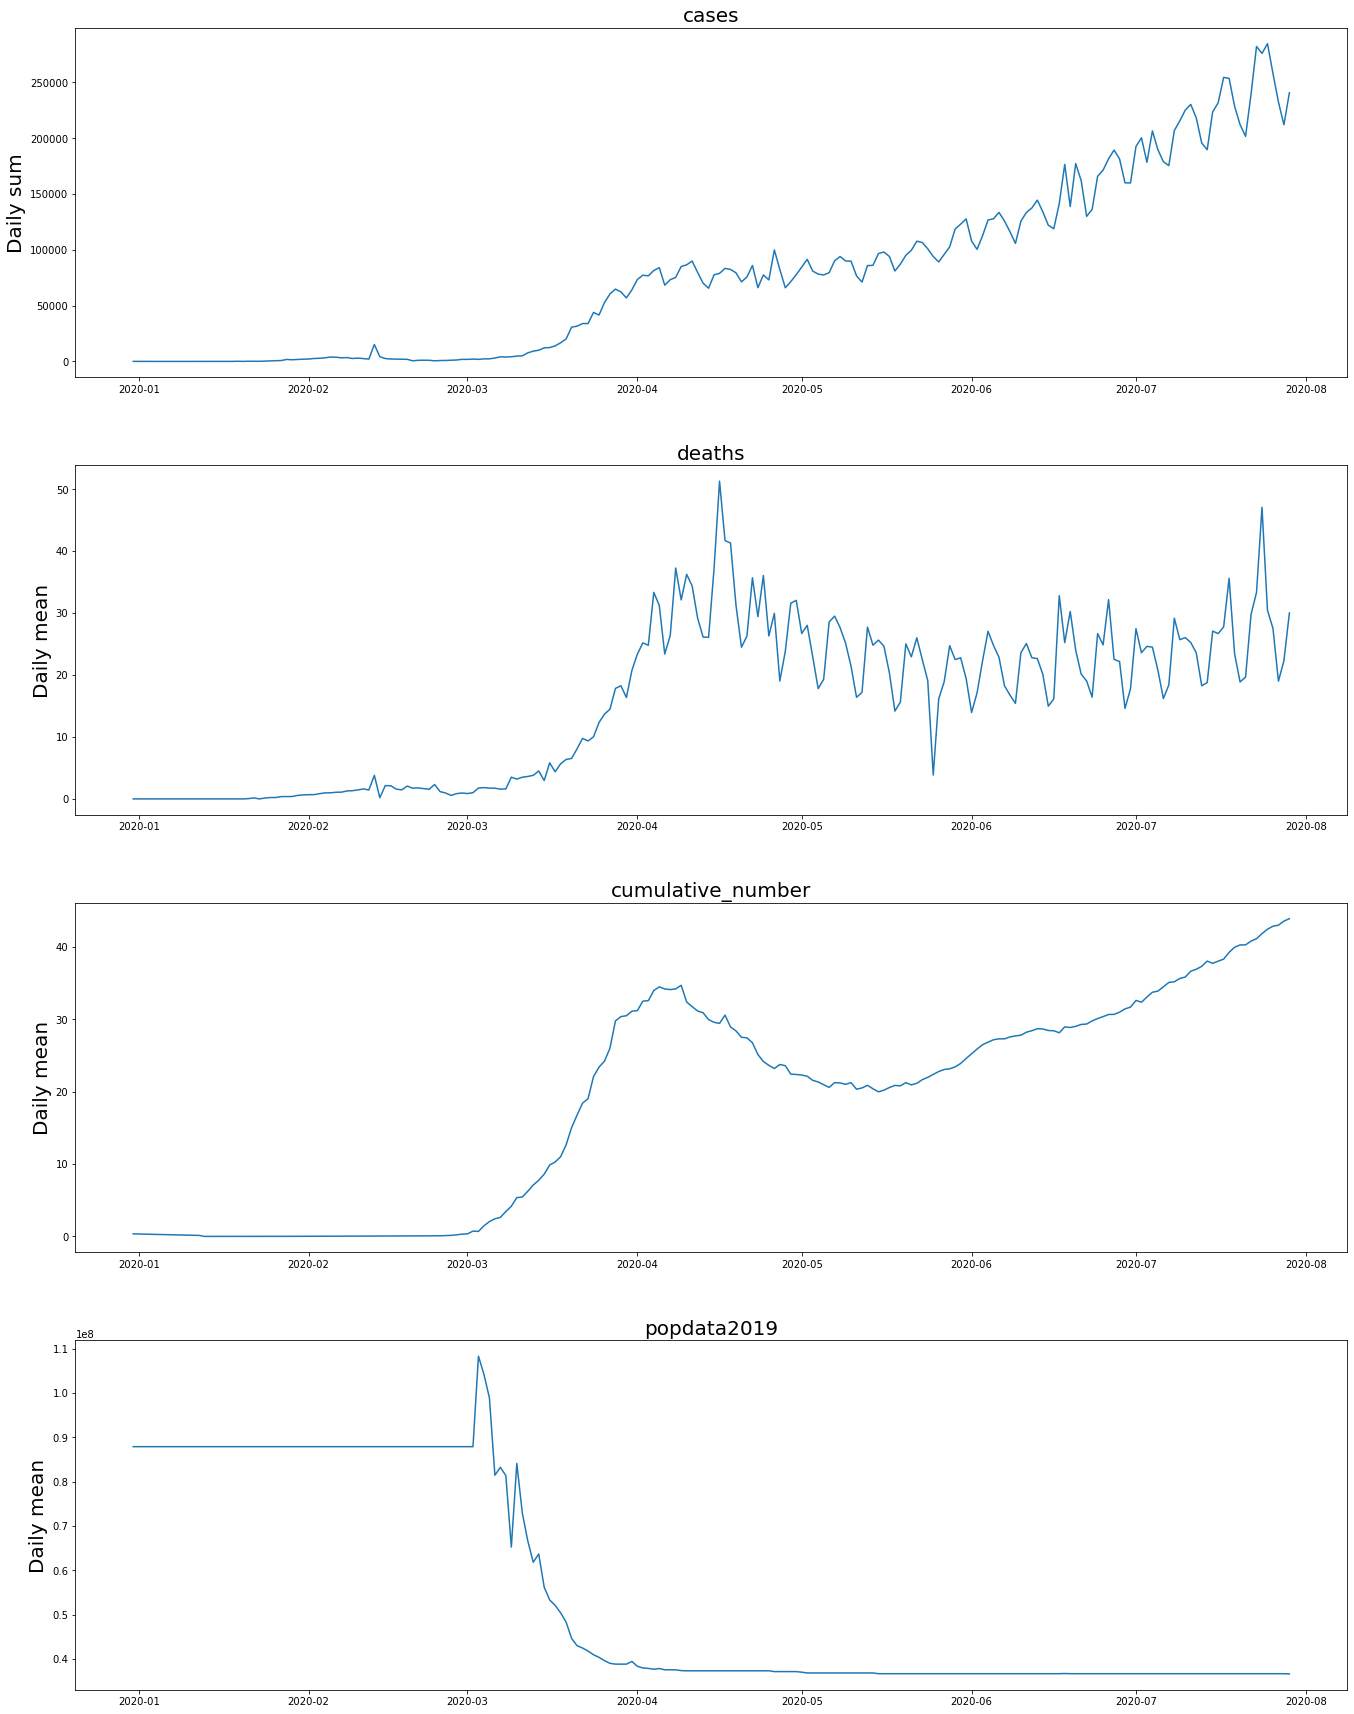

In [223]:
# Data plotting
fig, axes = plt.subplots(df_grouped.shape[1]-1, figsize=(20, 5 * df_grouped.shape[1]))

for idx, col_name in enumerate(df_grouped.columns.to_list()[1:]):
    axes[idx].plot(df_grouped.daterep, df_grouped[col_name])
    axes[idx].set_title(col_name, fontsize = 20)
    axes[idx].set_ylabel('Daily sum' if col_name == 'cases' else 'Daily mean', fontsize = 20)
plt.tight_layout(pad=5)

## Exercise №2

Analyze stationarity of a process (for mathematical expectation and variance) for all chosen variables. Make them more stationary if needed.

In [224]:
# Check stationarity
non_stat = []

for i in df_grouped.columns.to_list()[1:]:
    adf = adfuller(df_grouped[i])[1]
    if adf > 0.05:
        non_stat.append(i)
        print(f'Non stationary time-series: {i}, adfuller test: {adf}')

Non stationary time-series: cases, adfuller test: 0.9932830148780438
Non stationary time-series: deaths, adfuller test: 0.49663567809826425
Non stationary time-series: cumulative_number, adfuller test: 0.6530942750171755
Non stationary time-series: popdata2019, adfuller test: 0.5787588652247337


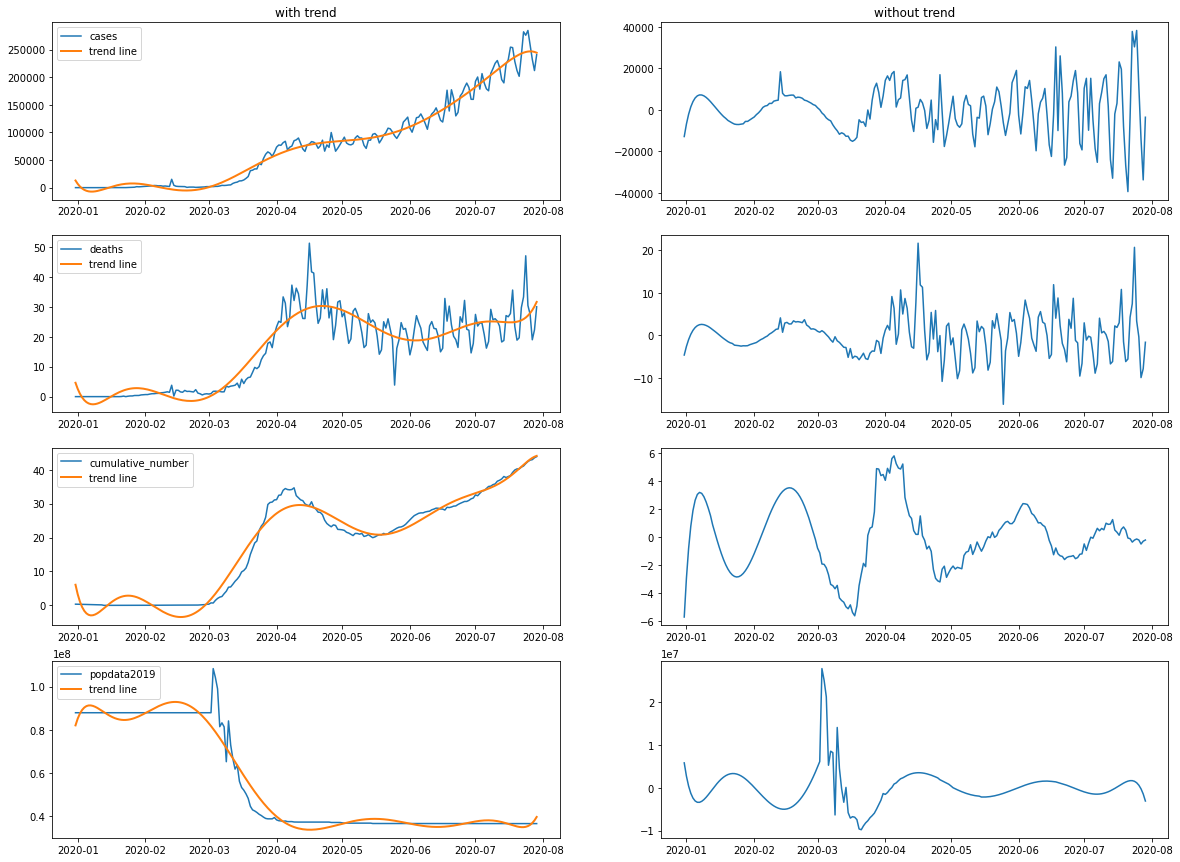

In [225]:
# Make time series more stationary

# Find the trend
def trendline(data, order=9):
    #polynomial trend
    trend = np.polyfit(data.index.values, list(data), order)
    return np.poly1d(trend)(data.index.values)

fig, axes = plt.subplots(df_grouped.shape[1]-1, 2, figsize=(20, 3 * df_grouped.shape[1]))
for i, col in enumerate(df_grouped.columns.to_list()[1:]):
    trend = trendline(df_grouped[col]) # build trend

    axes[i, 0].plot(df_grouped['daterep'], df_grouped[col], label=col)
    axes[i, 0].plot(df_grouped['daterep'], trend, linewidth=2, label='trend line')
    axes[i, 0].legend(loc="upper left")
    
    axes[i, 1].plot(df_grouped['daterep'], df_grouped[col]-trend) # remove trend

    if i == 0:
        axes[i, 0].set_title('with trend')
        axes[i, 1].set_title('without trend')

plt.show()

In [226]:
# Remove all trends
for i in non_stat:
    trend = trendline(df_grouped[i])
    df_grouped[i] = df_grouped[i]-trend

In [227]:
# Check stationarity after trend removing
non_stat = []
for i in df_grouped.columns.to_list()[1:]:
    adf = adfuller(df_grouped[i])[1]
    print(f'Time-series: {i}, adfuller test: {adf}')

Time-series: cases, adfuller test: 0.0008330227512344757
Time-series: deaths, adfuller test: 0.000979660352588229
Time-series: cumulative_number, adfuller test: 3.4556230018395404e-06
Time-series: popdata2019, adfuller test: 7.474529331922488e-05


## Exercise №3

Analyze covariance or correlation function for chosen target variables and mutual correlation functions among predictors and targets.

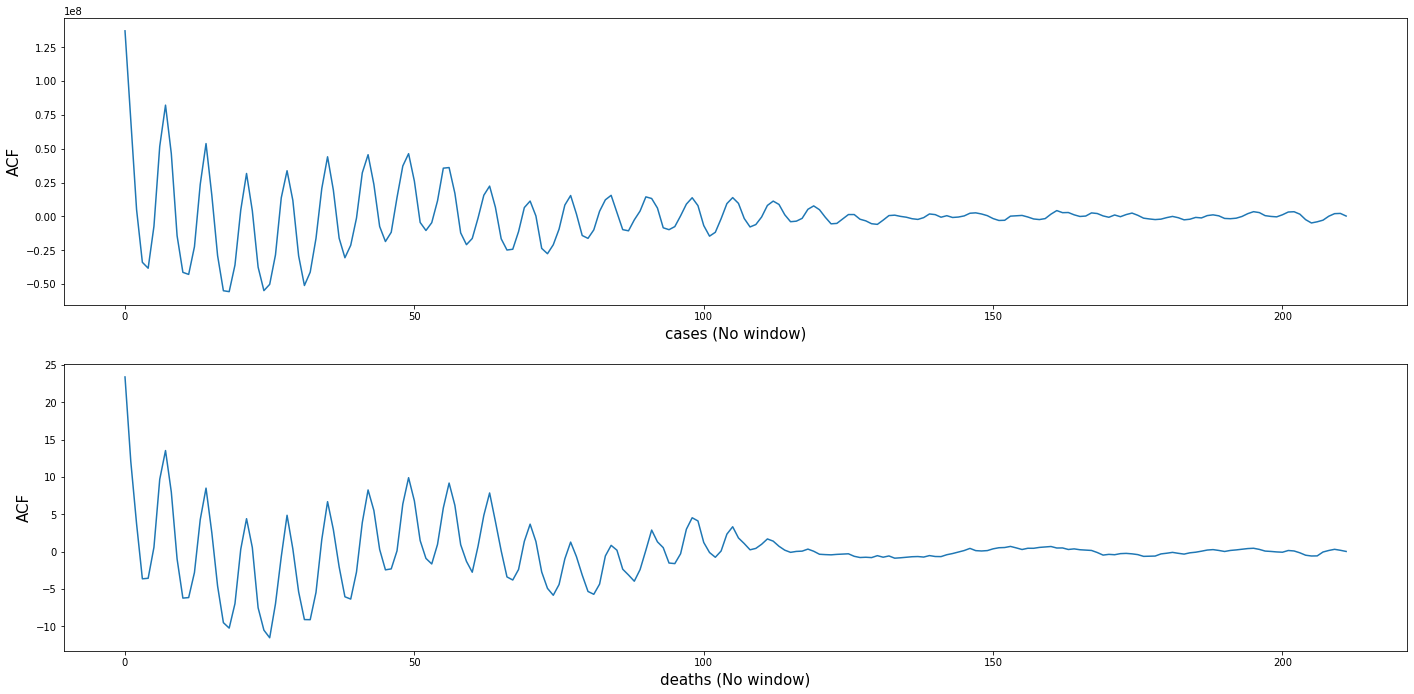

In [228]:
# Analyze covariance function

# Autocovariance without window
fig, axes = plt.subplots(len(target), figsize=(20, 5 * len(target)))

for idx, col_name in enumerate(target):
    axes[idx].plot(acovf(df_grouped[col_name],fft=False)) 
    axes[idx].set_xlabel(col_name + " (No window)", fontsize = 15)
    axes[idx].set_ylabel('ACF', fontsize = 15)
plt.tight_layout(pad=2)

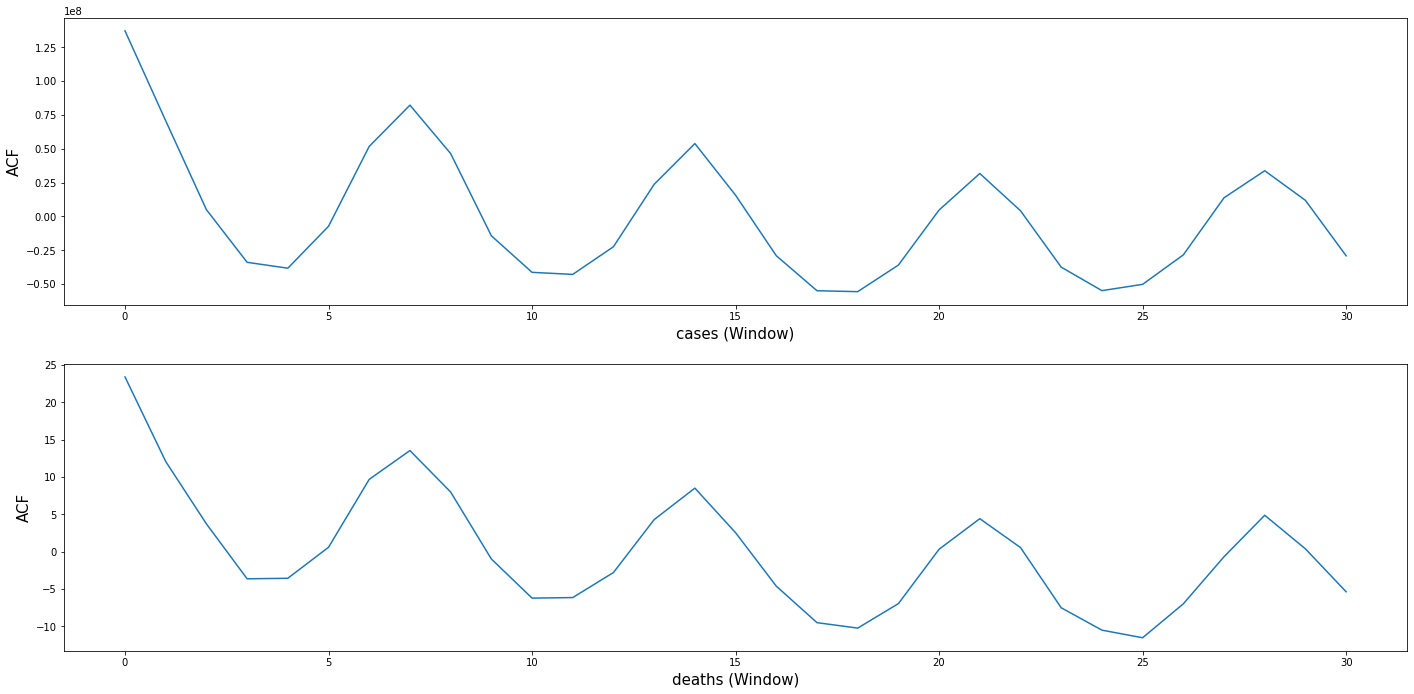

In [229]:
# Autocovariance with window
fig, axes = plt.subplots(len(target), figsize=(20, 5 * len(target)))

window_size = 30
for idx, col_name in enumerate(target):
    axes[idx].plot(acovf(df_grouped[col_name],nlag=window_size, fft=False)) 
    axes[idx].set_xlabel(col_name + " (Window)", fontsize = 15)
    axes[idx].set_ylabel('ACF', fontsize = 15)
plt.tight_layout(pad=2)

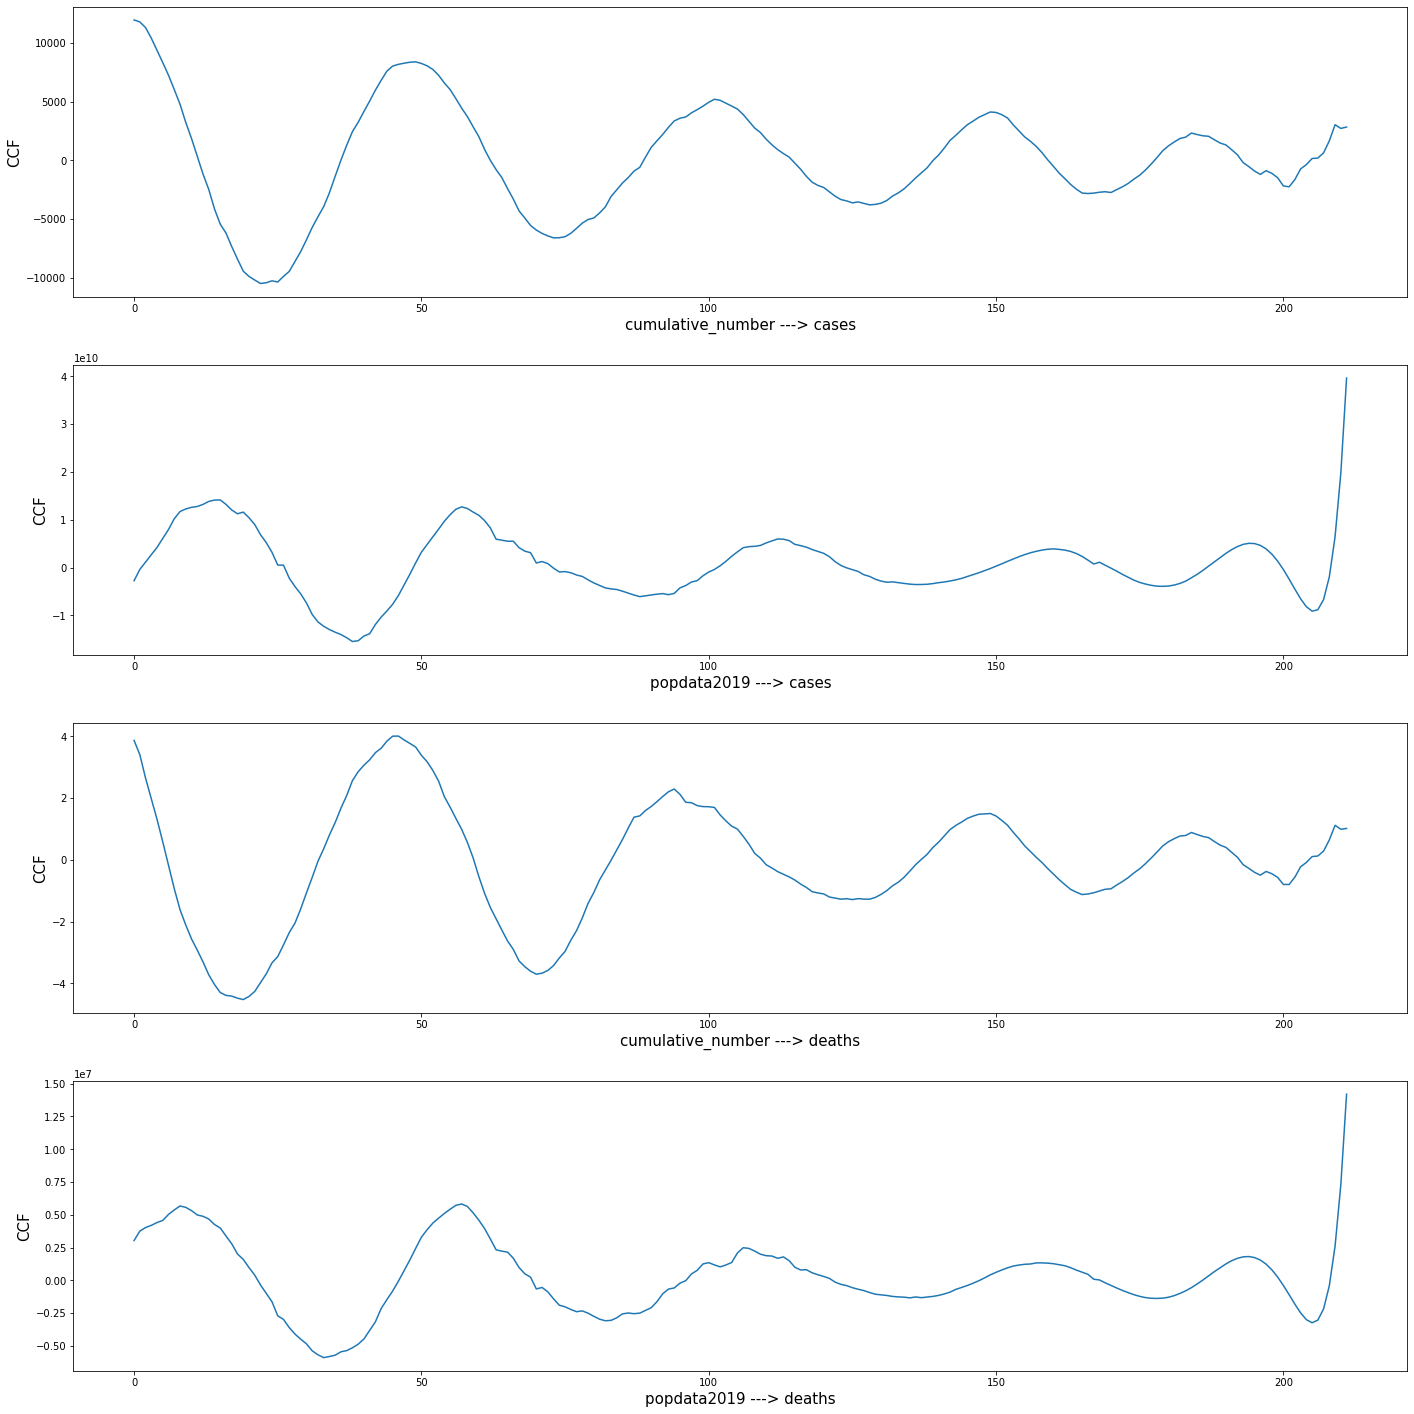

In [230]:
# Analize the cross-covariance between predictor ---> target
fig, axes = plt.subplots(len(target)+len(predictors), figsize=(20, 5 * (len(target)+len(predictors))))

idx = 0
for target_col in target:
    for pred_col in predictors:
        axes[idx].plot(ccovf(x=df_grouped[pred_col],y=df_grouped[target_col], fft=False)) 
        axes[idx].set_xlabel(f'{pred_col} ---> {target_col}', fontsize = 15)
        axes[idx].set_ylabel('CCF', fontsize = 15)
        idx += 1
plt.tight_layout(pad=2)

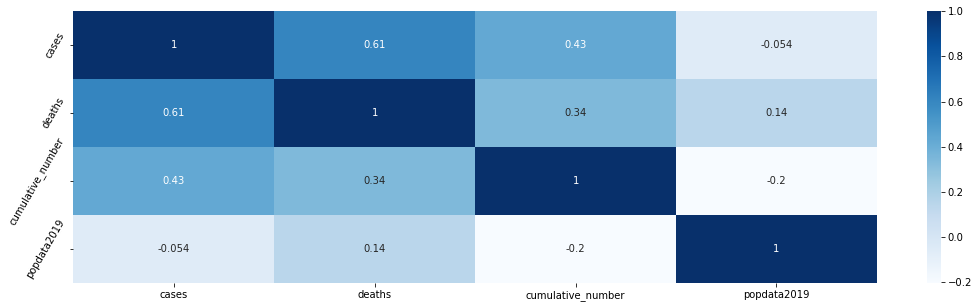

In [239]:
# Show Cross correlation matrix

# Correlation coefficients
plt.figure(figsize=(18, 5))
sns.heatmap(df_grouped.corr(), cmap='Blues', annot=True)
plt.yticks(rotation=60)
plt.show()

## Exercise №4

Filter high frequencies (noise) with chosen 2 filters for target variables

In [259]:
# Prepare data for FEDOT
input_data_list = []

# Define task - time series forecasting
# and forecast horizon 
task = Task(TaskTypesEnum.ts_forecasting, TsForecastingParams(forecast_length=25))

# Convert into numpy array first
for targ_name in target:
    time_series = np.array(df_grouped[targ_name])
    input_data = InputData(idx=np.arange(0, len(time_series)),
                        features=time_series, target=time_series,
                        task=task, data_type=DataTypesEnum.ts)

    input_data_list.append(input_data)

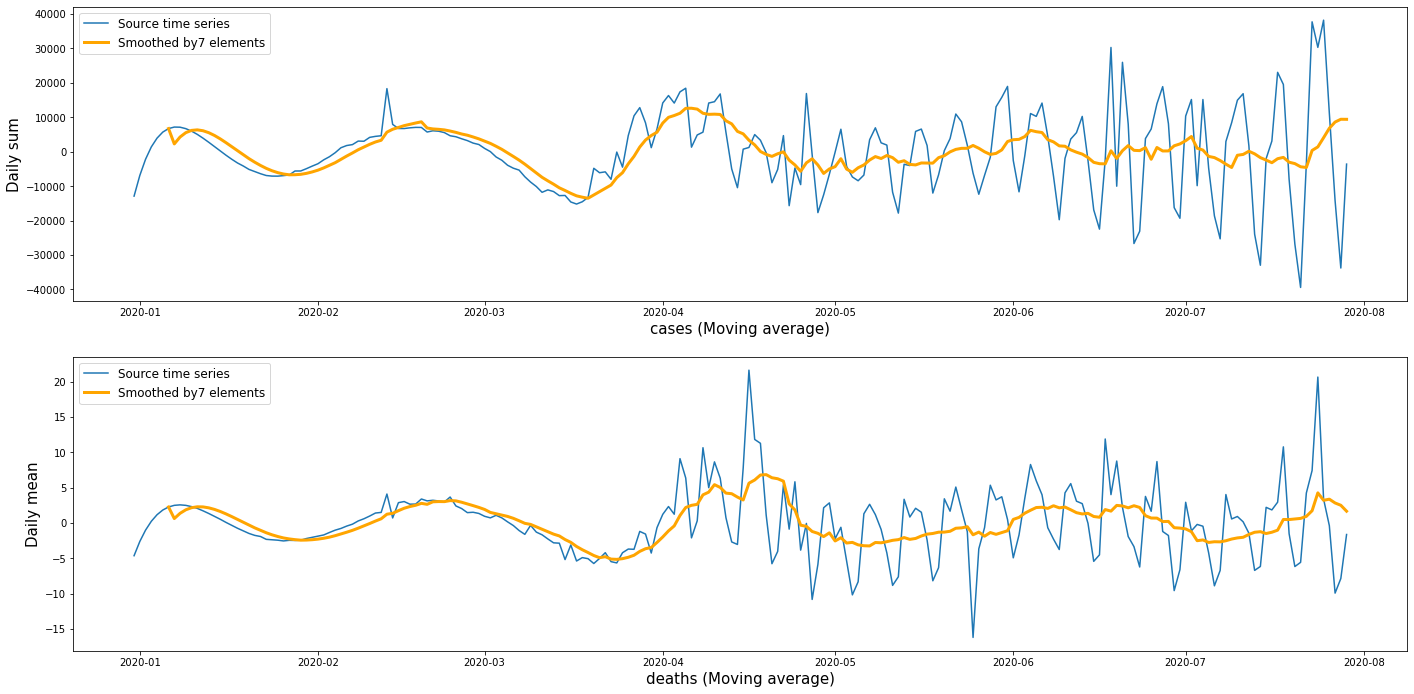

In [281]:
# Moving average filter 
window_size = 7

smoothing_node = PrimaryNode('smoothing') 
smoothing_node.custom_params = {'window_size': window_size}

def node_fit_predict(node, input_data):
    """ Fit node and make prediction """
    node.fit(input_data)
    smoothed_output = node.predict(input_data)
    return smoothed_output

roll_filt_targs = []

fig, axes = plt.subplots(len(target), figsize=(20, 5 * len(target)))

for idx, col_name in enumerate(target):
    smoothed_output = node_fit_predict(smoothing_node, input_data_list[idx])
    roll_filt_targs.append(smoothed_output.predict[window_size-1:]) # Cut First elements, that coinside with pure data (input)

    axes[idx].plot(df_grouped.daterep, input_data_list[idx].target, label='Source time series')
    axes[idx].plot(df_grouped.daterep[window_size-1:], 
                   smoothed_output.predict[window_size-1:], 
                   label='Smoothed by'+str(window_size)+' elements', 
                   c="orange", 
                   linewidth=3)
    
    axes[idx].set_xlabel(col_name+" (Moving average)", fontsize = 15)
    axes[idx].set_ylabel('Daily sum' if col_name == 'cases' else 'Daily mean', fontsize = 15)
    axes[idx].legend(loc="upper left", fontsize=12)
plt.tight_layout(pad=2)

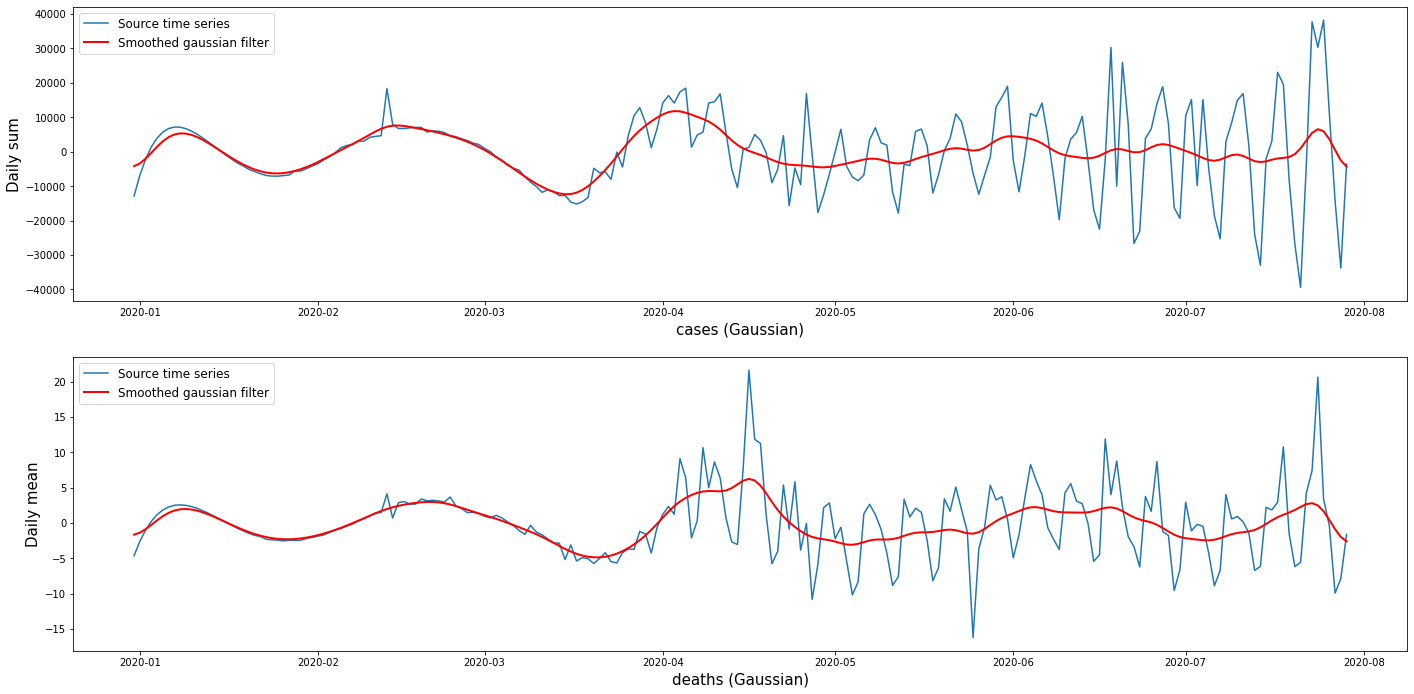

In [280]:
# Gaussian filter
gaussian_node = PrimaryNode('gaussian_filter') 
gaussian_node.custom_params = {'sigma': 3}

# Prepare data for spectral analisys
gaus_filt_targs = []
pure_targs = []

fig, axes = plt.subplots(len(target), figsize=(20, 5 * len(target)))

for idx, col_name in enumerate(target):
    smoothed_gaussian = node_fit_predict(gaussian_node, input_data_list[idx])
    gaus_filt_targs.append(smoothed_gaussian.predict)
    pure_targs.append(input_data_list[idx].target)
    
    axes[idx].plot(df_grouped.daterep, input_data_list[idx].target, label='Source time series')
    axes[idx].plot(df_grouped.daterep, 
                   smoothed_gaussian.predict, 
                   label='Smoothed gaussian filter', 
                   linewidth=2, 
                   c='red')
    
    axes[idx].set_xlabel(col_name+" (Gaussian)", fontsize = 15)
    axes[idx].set_ylabel('Daily sum' if col_name == 'cases' else 'Daily mean', fontsize = 15)
    axes[idx].legend(loc="upper left", fontsize=12)
plt.tight_layout(pad=2)

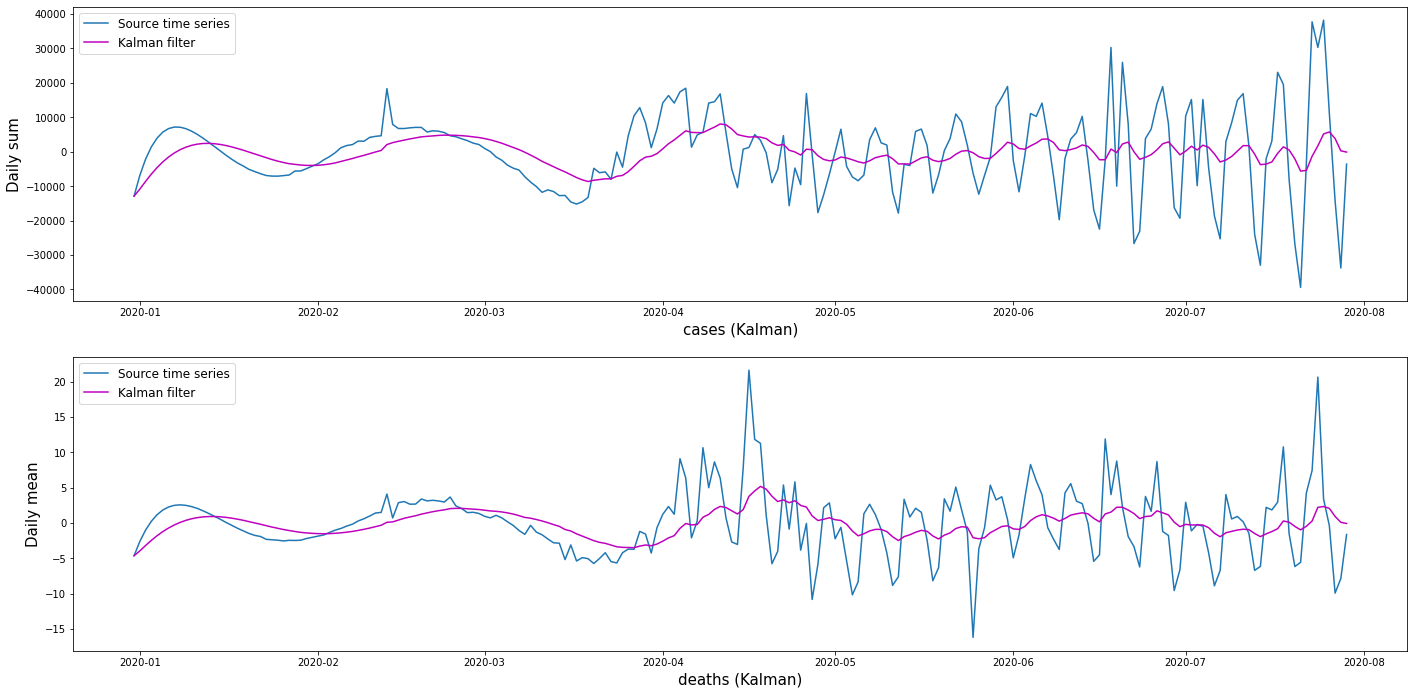

In [291]:
# Kalman filter
def kalman_filter(data):
    
    kf = KalmanFilter(transition_matrices=[1],  # A transition matrix of states between times t и t+1 
          observation_matrices=[1],  # C surveillance matrix
          initial_state_mean=data[0],  # average initial state
          initial_state_covariance=[1],  # covariance of the initial state distribution
          observation_covariance=[1],  # R covariance observation matrix 
          transition_covariance= 0.01)  # Q covariance transition matrix of states 
    
    state_means_0, _ = kf.filter(data)
    state_means_0 = [w[0] for w in state_means_0]
    return state_means_0

fig, axes = plt.subplots(len(target), figsize=(20, 5 * len(target)))

Kalman_filt_targs = []
for idx, col_name in enumerate(target):
    kalm = kalman_filter(np.array(df_grouped[col_name]))
    Kalman_filt_targs.append(kalm)
    
    axes[idx].plot(df_grouped.daterep, df_grouped[col_name], label='Source time series')
    axes[idx].plot(df_grouped.daterep, kalm, label='Kalman filter', c='m')
    
    axes[idx].set_xlabel(col_name+" (Kalman)", fontsize = 15)
    axes[idx].set_ylabel('Daily sum' if col_name == 'cases' else 'Daily mean', fontsize = 15)
    axes[idx].legend(loc="upper left", fontsize=12)
plt.tight_layout(pad=2)

## Exercise 5

Estimate spectral density function for with and without filtering

/tmp/ipykernel_11008/2448649238.py:5: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  bartlett = signal.hanning(M=window_size)


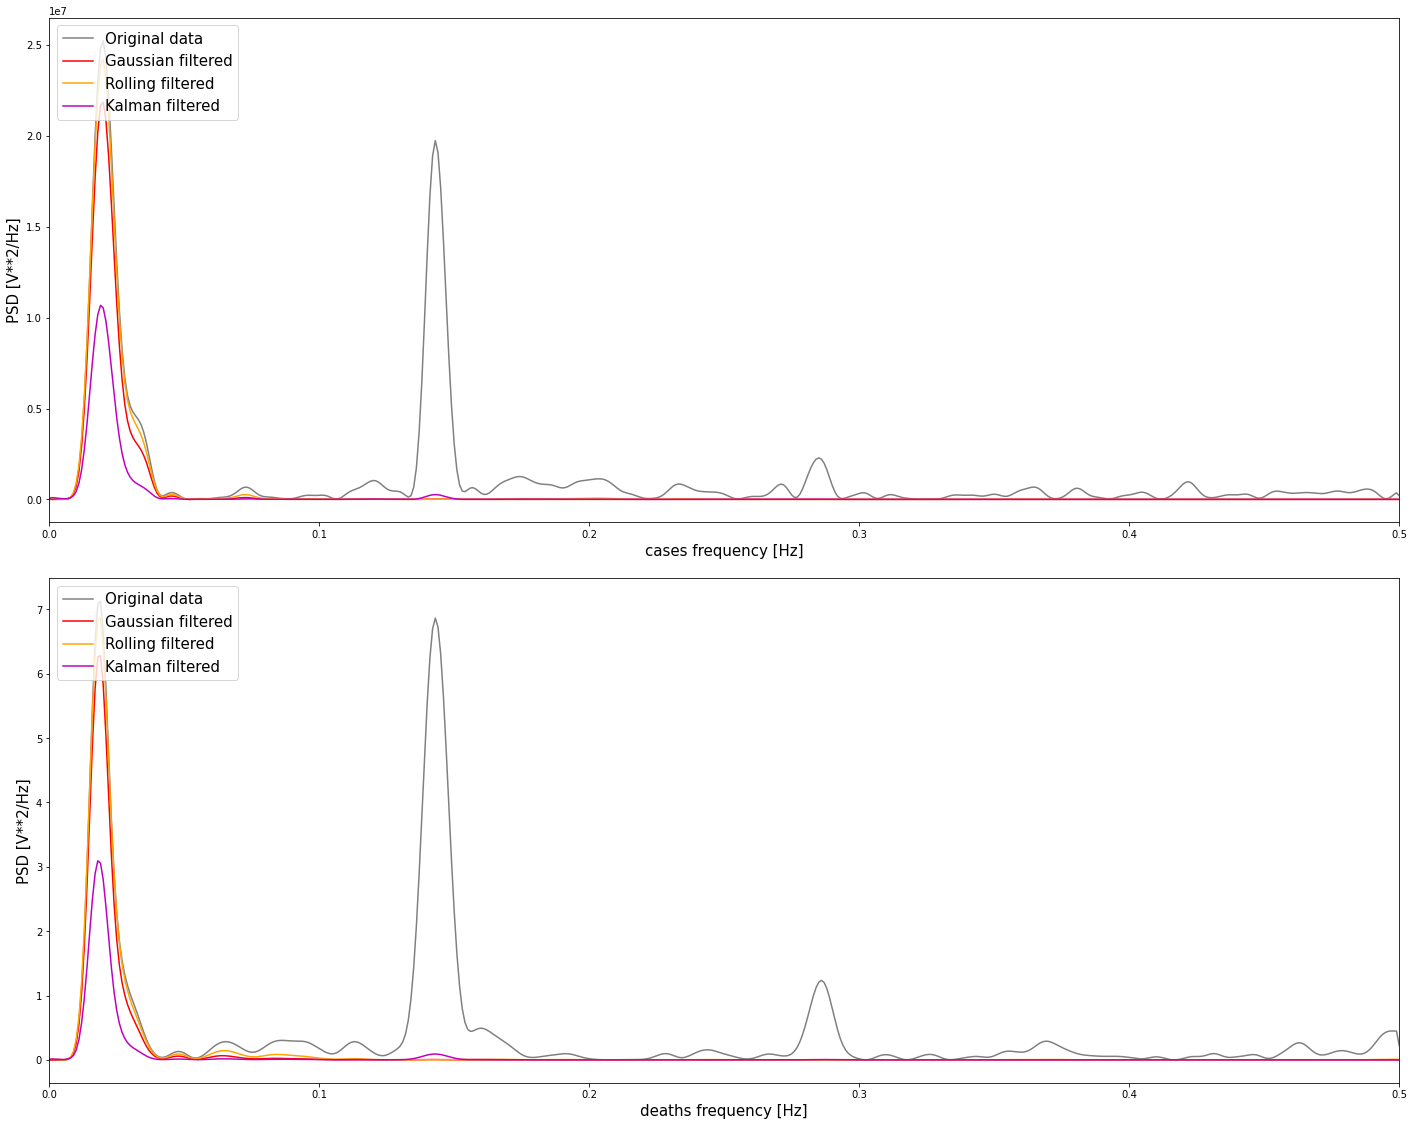

In [292]:
# Plot spectrum for source and filtered data
window_size = 72
blackman = signal.blackman(M=window_size)
bartlett = signal.hanning(M=window_size)

fig, axes = plt.subplots(len(target), figsize=(20, 8 * len(target)))

for col_idx, col_name in enumerate(target):
    f, Pxx_den = signal.welch(pure_targs[col_idx], fs=1, scaling='spectrum', nfft = 1000) # Spectrum for orig data
    f_flt_g, Pxx_flt_g = signal.welch(gaus_filt_targs[col_idx], fs=1, nfft = 1000, scaling='spectrum')
    f_flt_r, Pxx_flt_r = signal.welch(roll_filt_targs[col_idx], fs=1, nfft = 1000, scaling='spectrum')
    f_flt_k, Pxx_flt_k = signal.welch(Kalman_filt_targs[col_idx], fs=1, nfft = 1000, scaling='spectrum')

    axes[col_idx].plot(f, Pxx_den, color="grey", label='Original data')
    axes[col_idx].plot(f_flt_g, Pxx_flt_g, color="red", label='Gaussian filtered')
    axes[col_idx].plot(f_flt_r, Pxx_flt_r, color="orange", label='Rolling filtered')
    axes[col_idx].plot(f_flt_k, Pxx_flt_k, color="m", label='Kalman filtered')

    axes[col_idx].set_xlabel(col_name+' frequency [Hz]', fontsize = 15)
    axes[col_idx].set_ylabel(u'PSD [V**2/Hz]', fontsize = 15)
    axes[col_idx].set_xlim((0,0.5))
    axes[col_idx].legend(loc="upper left", fontsize = 15)
plt.tight_layout(pad=2)

## Exercise №6

Built auto-regression model filtered and non-filtered data. To analyze residual error and to define appropriate order of model

In [294]:
# Prepare data for FEDOT
orig_input_data_list = []
orig_train = []
orig_test = []
filter_input_data_list = []
filter_train = []
filter_test = []

# Define task - time series forecasting
# and forecast horizon 
task = Task(TaskTypesEnum.ts_forecasting, TsForecastingParams(forecast_length=40))

# Prepare original data
for col_idx in range(len(target)):
    time_series = pure_targs[col_idx] 
    input_data = InputData(idx=np.arange(0, len(time_series)),
                        features=time_series, target=time_series,
                        task=task, data_type=DataTypesEnum.ts)
    train, test = train_test_data_setup(input_data)

    orig_input_data_list.append(input_data)
    orig_train.append(train)
    orig_test.append(test)

# Prepare filtered data
for col_idx in range(len(target)):
    time_series = gaus_filt_targs[col_idx]
    input_data = InputData(idx=np.arange(0, len(time_series)),
                        features=time_series, target=time_series,
                        task=task, data_type=DataTypesEnum.ts)
    train, test = train_test_data_setup(input_data)

    filter_input_data_list.append(input_data)
    filter_train.append(train)
    filter_test.append(test)

Start pipeline tuning
Hyperparameters optimization start
100%|████████| 500/500 [00:14<00:00, 34.92trial/s, best loss: 7601.510425495881]
Hyperparameters optimization finished
Return tuned pipeline due to the fact that obtained metric 7601.510 equal or smaller than initial (+ 5% deviation) 10577.031
Tuning was finished
Trained operation is not actual because you are using new dataset for training. Parameter use_fitted value changed to False
Pipeline structure:
{'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 16.62148720764703, 'lag_2': 57.42126830651385}
Start pipeline tuning
Hyperparameters optimization start
100%|████████| 500/500 [00:18<00:00, 26.38trial/s, best loss: 2.843285418864716]
Hyperparameters optimization finished
Return tuned pipeline due to the fact that obtained metric 2.843 equal or smaller than initial (+ 5% deviation) 3.423
Tuning was finished
Trained operation is not actual because you are using new dataset for training. Parameter use_fitted value changed to 

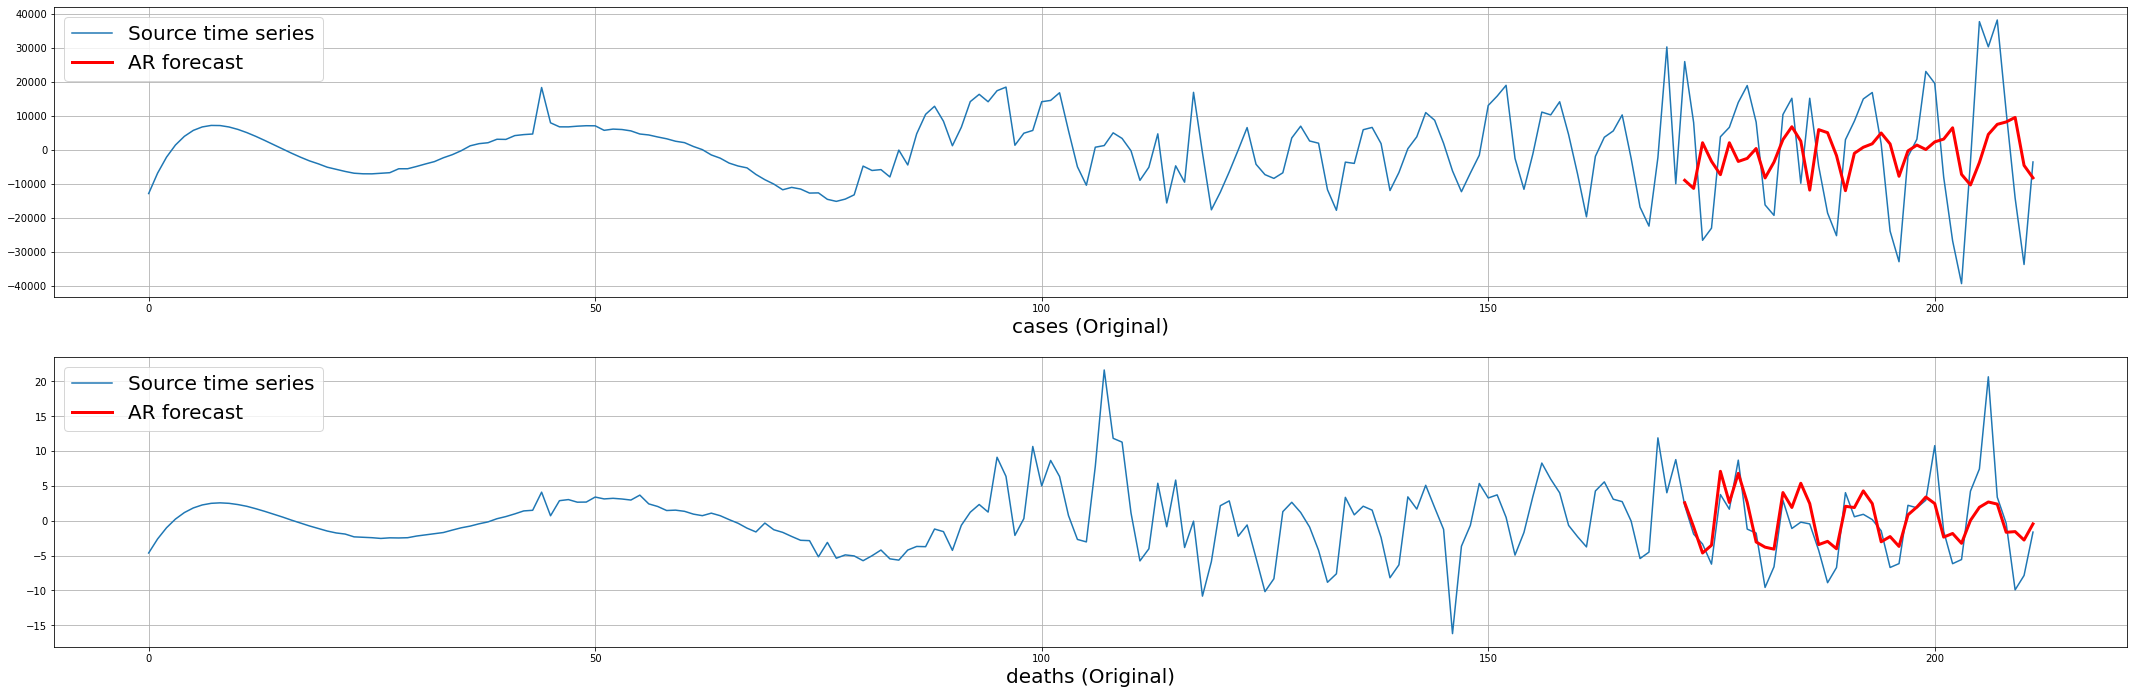

In [302]:
# AR model for original (non-filtered) data
fig, axes = plt.subplots(len(target), figsize=(30, 5 * len(target)))

for col_idx, col_name in enumerate(target):
    pipeline = Pipeline(PrimaryNode('ar'))
    pipeline = pipeline.fine_tune_all_nodes(loss_function=mean_absolute_error,
                                            loss_params=None, input_data=orig_train[col_idx],
                                            iterations=500, timeout=5)
                                            #cv_folds=1, validation_blocks=2)

    fitted_vals = pipeline.fit(orig_train[col_idx])
    forecast = pipeline.predict(orig_test[col_idx])

    axes[col_idx].plot(orig_input_data_list[col_idx].idx, 
                       orig_input_data_list[col_idx].target, 
                       label='Source time series')
    axes[col_idx].plot(forecast.idx, np.ravel(forecast.predict), label='AR forecast', c='red', linewidth=3)
    axes[col_idx].grid()
    axes[col_idx].legend(fontsize = 20)
    axes[col_idx].set_xlabel(col_name+' (Original)', fontsize = 20)

    pipeline.print_structure()
plt.tight_layout(pad=2)

Start pipeline tuning
Hyperparameters optimization start
100%|███████| 500/500 [00:19<00:00, 25.43trial/s, best loss: 1226.9732647518197]
Hyperparameters optimization finished
Return tuned pipeline due to the fact that obtained metric 1226.973 equal or smaller than initial (+ 5% deviation) 8612.103
Tuning was finished
Trained operation is not actual because you are using new dataset for training. Parameter use_fitted value changed to False
Pipeline structure:
{'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 13.117204896248243, 'lag_2': 36.71506829962277}
Start pipeline tuning
Hyperparameters optimization start
100%|█████████| 500/500 [00:19<00:00, 26.21trial/s, best loss: 0.75297951351518]
Hyperparameters optimization finished
Return tuned pipeline due to the fact that obtained metric 0.753 equal or smaller than initial (+ 5% deviation) 2.224
Tuning was finished
Trained operation is not actual because you are using new dataset for training. Parameter use_fitted value changed to 

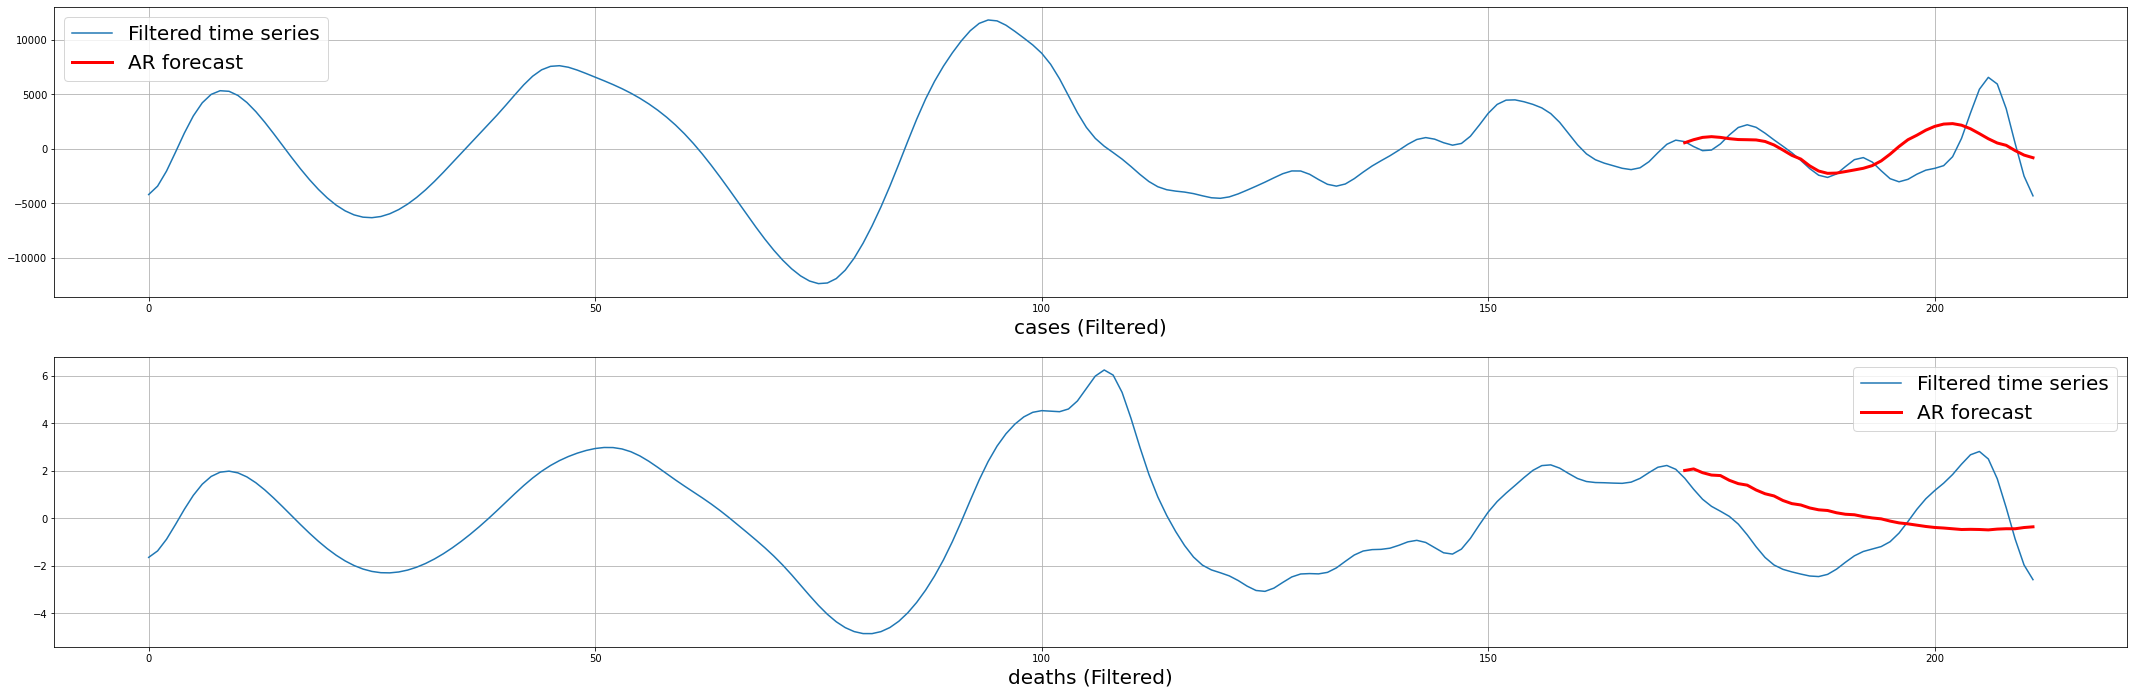

In [303]:
# AR model for filtered data
fig, axes = plt.subplots(len(target), figsize=(30, 5 * len(target)))

for col_idx, col_name in enumerate(target):
    pipeline = Pipeline(PrimaryNode('ar'))
    pipeline = pipeline.fine_tune_all_nodes(loss_function=mean_absolute_error,
                                            loss_params=None, input_data=filter_train[col_idx],
                                            iterations=500, timeout=5)
                                            #cv_folds=3, validation_blocks=2)

    fitted_vals = pipeline.fit(filter_train[col_idx])
    forecast = pipeline.predict(filter_test[col_idx])

    axes[col_idx].plot(filter_input_data_list[col_idx].idx, 
                       filter_input_data_list[col_idx].target, 
                       label='Filtered time series')
    axes[col_idx].plot(forecast.idx, np.ravel(forecast.predict), label='AR forecast', c='red', linewidth=3)
    axes[col_idx].grid()
    axes[col_idx].legend(fontsize = 20)
    axes[col_idx].set_xlabel(col_name+' (Filtered)', fontsize = 20)

    pipeline.print_structure()
plt.tight_layout(pad=2)

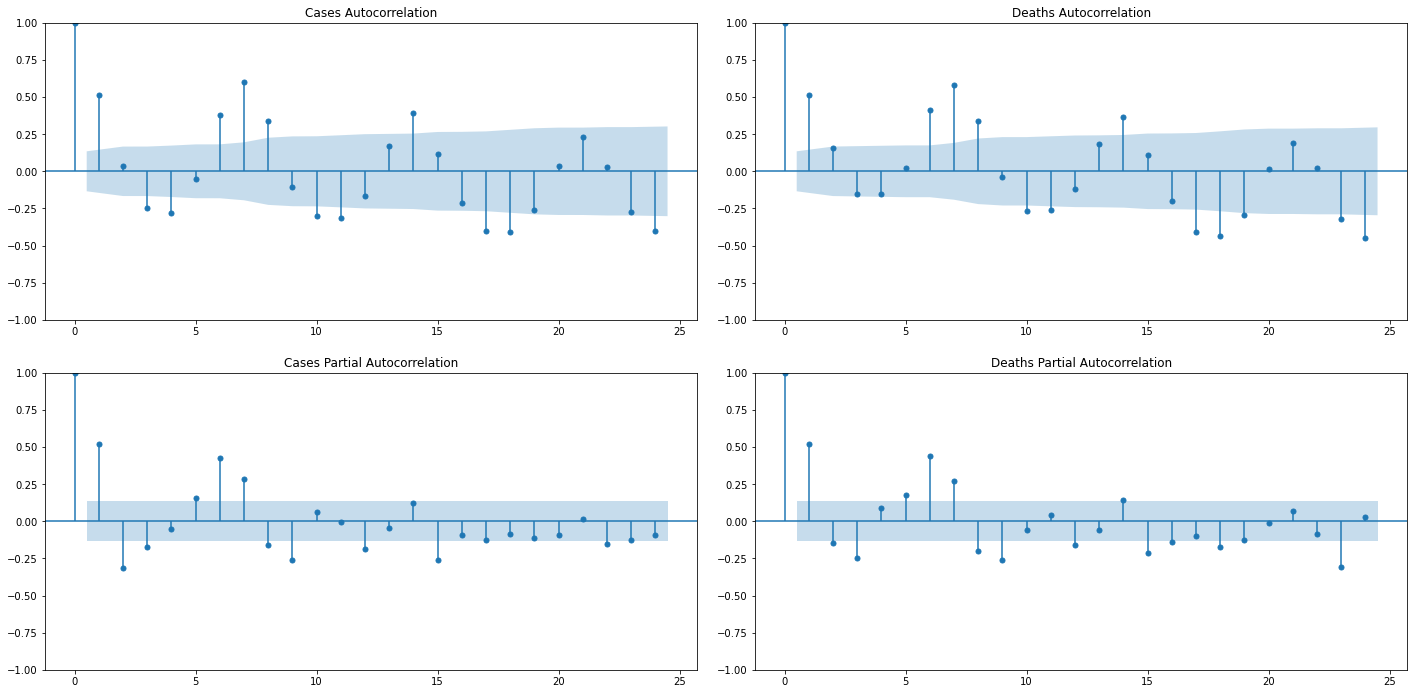

In [313]:
# Plotting ACF & PACF
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

plot_acf(df_grouped.cases, ax=axes[0,0], title='Cases Autocorrelation')
plot_pacf(df_grouped.cases, ax=axes[1,0], title='Cases Partial Autocorrelation')

plot_acf(df_grouped.deaths, ax=axes[0,1], title='Deaths Autocorrelation')
plot_pacf(df_grouped.deaths, ax=axes[1,1], title='Deaths Partial Autocorrelation')

plt.tight_layout(pad=2)

In [387]:
# Build ARIMA Model
def arima_forecast(X_train, X_test, y_train, y_test, target_name, order):
    model = ARIMA(y_train, exog=X_train, order=order).fit()  

    # Forecast
    predictions = model.forecast(15, exog=X_test, alpha=0.05)  # 95% conf

    # Plot
    plt.figure(figsize=(20,6), dpi=100)

    plt.axvline(x=X_train.shape[0], c='r', linestyle='--', label='devide-train/test')
    plt.plot(y_train, label='Train data')
    plt.plot(np.arange(X_train.shape[0], X.shape[0]), y_test, label='Real data')
    plt.plot(np.arange(X_train.shape[0], X.shape[0]), predictions, label='Predictions', c='r')

    plt.title(f'{target_name} predictions by ARIMA model, MAPE: {
                    mean_absolute_percentage_error(y_test, predictions)*100}')
    plt.legend(loc='upper left', fontsize=10)
    plt.show()

In [388]:
# Make forecast for CASES target
X = df_grouped[['cumulative_number', 'popdata2019']]
y = df_grouped.cases

X = np.array(X).squeeze()
y = np.array(y).squeeze()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=15, shuffle=False)

# AUTO ARIMA model
model = pm.auto_arima(y_train,
                    X=X_train, trace=True, max_P = 5, max_Q = 5, max_D = 4, start_P = 0, start_Q = 0,
                    seasonal = False, m = 15, max_p = 9, max_q = 5,
                    error_action='ignore',  
                    suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=4097.230, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4985.190, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=4118.947, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=4109.178, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=4088.288, Time=0.22 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=4119.594, Time=0.17 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=4110.763, Time=0.14 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=4081.064, Time=0.33 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=4095.844, Time=0.15 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=4086.358, Time=0.45 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=4122.078, Time=0.12 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=4100.322, Time=0.12 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=4033.872, Time=0.33 sec
 ARIMA(3,0,4)(0,0,0)[0]             : AIC=4034.569, Time=0.53 sec
 ARIMA(2,0,5)(0,0,0)[0]          

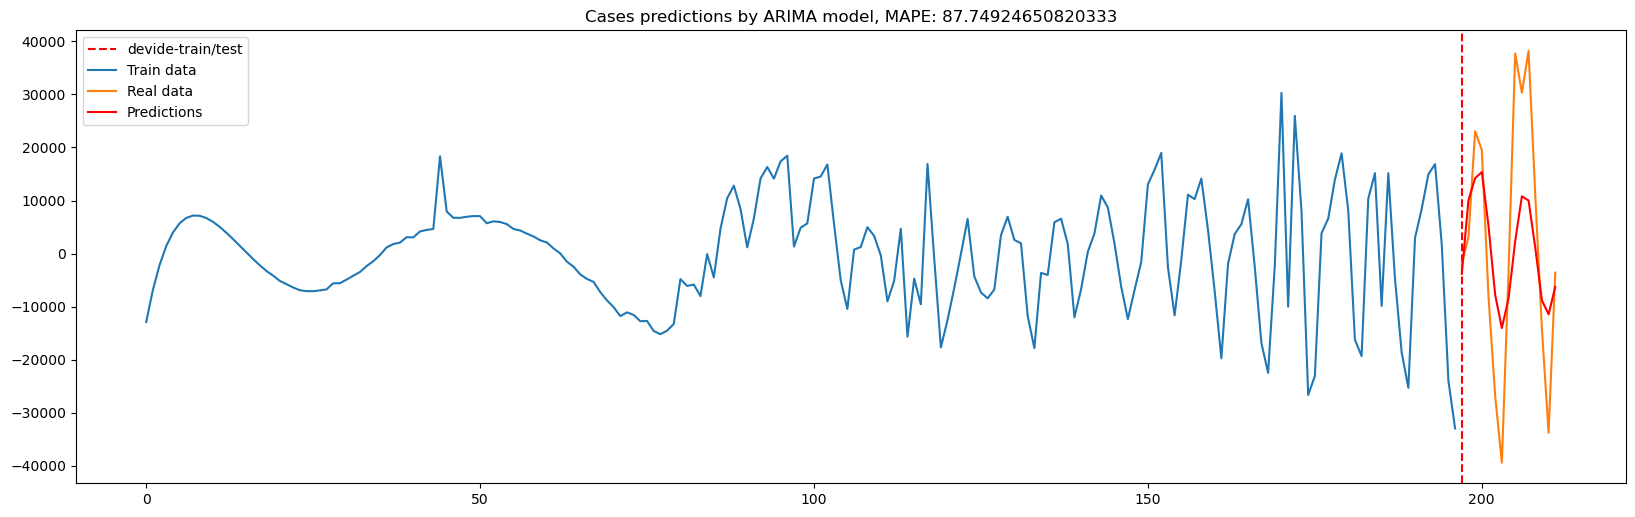

In [389]:
arima_forecast(X_train, X_test, y_train, y_test, 'Cases', (2,0,4))

In [385]:
# Make forecast for DEATHS target
X = df_grouped[['cumulative_number', 'popdata2019']]
y = df_grouped.deaths

X = np.array(X).squeeze()
y = np.array(y).squeeze()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=15, shuffle=False)

# AUTO ARIMA model
model = pm.auto_arima(y_train,
                    X=X_train, trace=True, max_P = 5, max_Q = 5, max_D = 4, start_P = 0, start_Q = 0,
                    seasonal = False, m = 15, max_p = 9, max_q = 5,
                    error_action='ignore',  
                    suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1049.897, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1965.851, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1084.906, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1088.970, Time=0.16 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1088.006, Time=0.26 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1137.489, Time=0.10 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=1055.933, Time=0.31 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=1040.626, Time=0.32 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=1093.462, Time=0.11 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=1169.778, Time=0.14 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=1273.799, Time=0.38 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=1122.380, Time=0.32 sec
 ARIMA(3,0,4)(0,0,0)[0]             : AIC=1178.171, Time=0.17 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=1042.591, Time=0.38 sec

Best model:  ARIMA(2,0,3)(0,0,0)

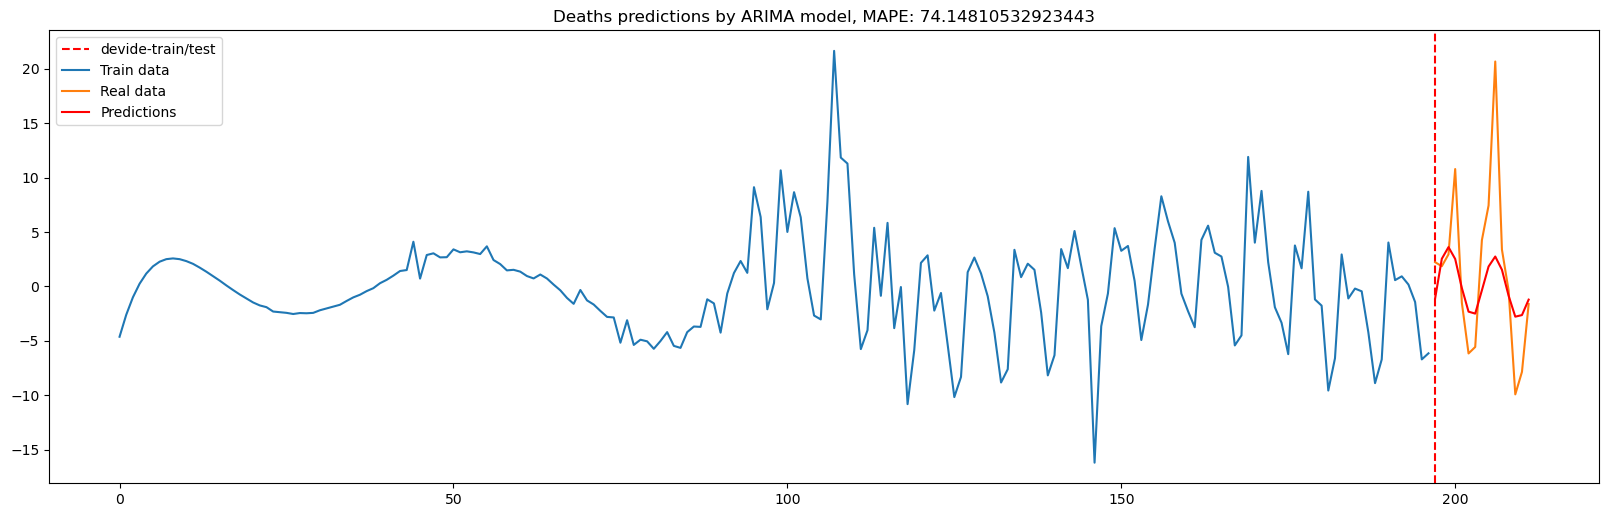

In [386]:
arima_forecast(X_train, X_test, y_train, y_test, 'Deaths', (2,0,3))